In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

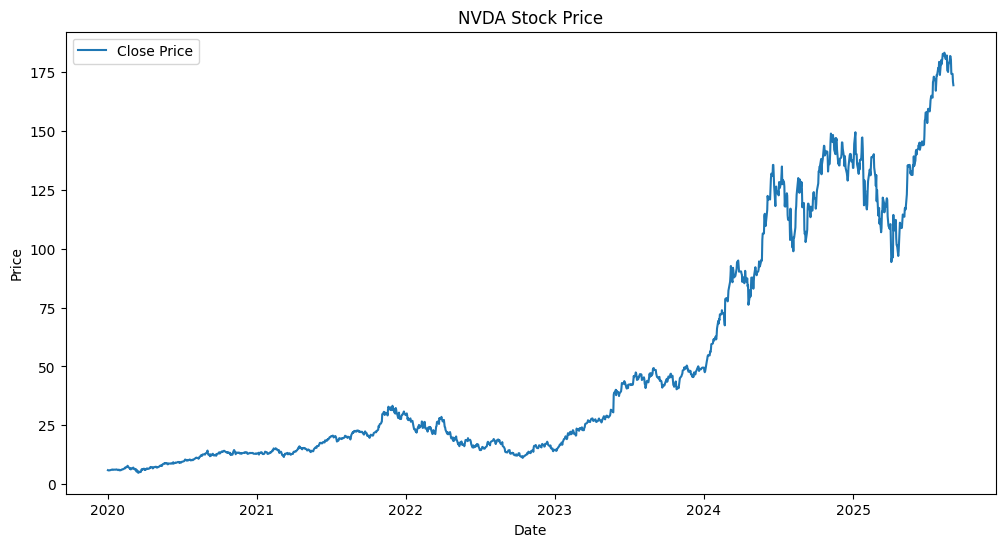

In [2]:
ticker = "NVDA"
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.Ticker(ticker).history(start=start_date, end=end_date)
close = data["Close"].dropna()
close = close.asfreq("B")  # Business day frequency
close = close.ffill()      # Fill missing

# Original Series
plt.figure(figsize=(12,6))
plt.plot(close, label="Close Price")
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()

In [3]:
# Stationarity Check
adf_test = adfuller(close)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: 0.535406113470217
p-value: 0.9859104217060939


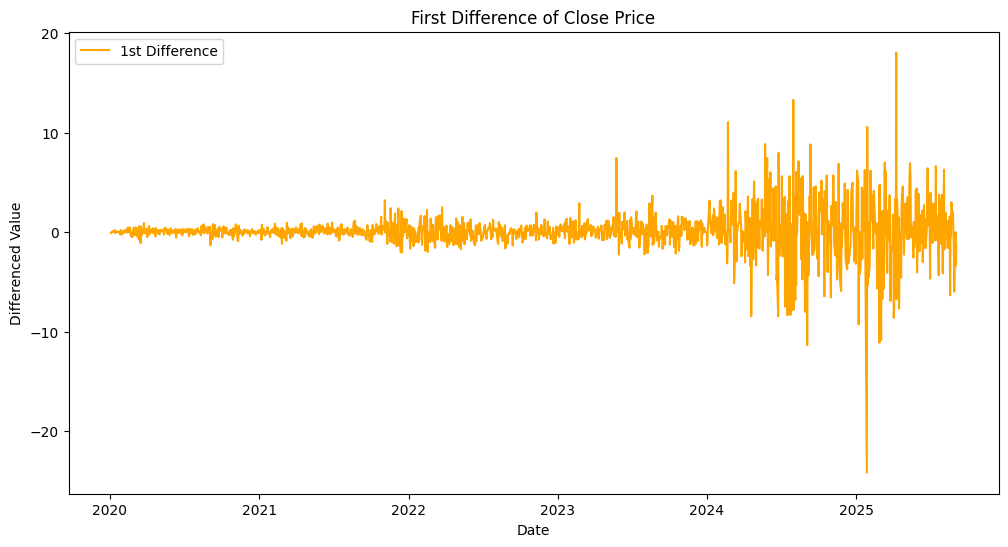

In [4]:
# First Differencing
close_diff = close.diff().dropna()

plt.figure(figsize=(12,6))
plt.plot(close_diff, color="orange", label="1st Difference")
plt.title("First Difference of Close Price")
plt.xlabel("Date"); plt.ylabel("Differenced Value"); plt.legend()
plt.show()

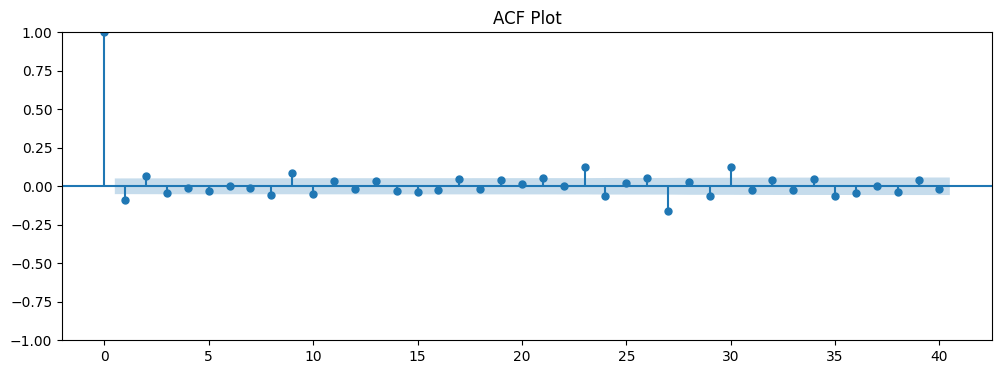

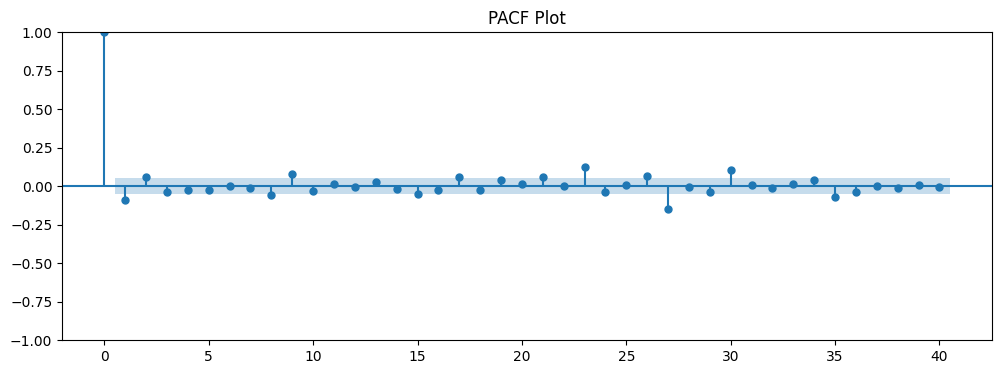

In [5]:
# ACF and PACF
plt.figure(figsize=(12,4))
plot_acf(close_diff, lags=40, ax=plt.gca())
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(close_diff, lags=40, ax=plt.gca(), method="ywm")
plt.title("PACF Plot")
plt.show()

In [6]:
# Train-Test Split
train_size = int(len(close) * 0.8)
train, test = close[:train_size], close[train_size:]

# Fit ARIMA Model
p, d, q = 1, 1, 1   
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1184
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1905.354
Date:                Thu, 04 Sep 2025   AIC                           3816.708
Time:                        00:25:39   BIC                           3831.935
Sample:                    01-02-2020   HQIC                          3822.448
                         - 07-16-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8299      0.034    -24.532      0.000      -0.896      -0.764
ma.L1          0.8908      0.026     34.231      0.000       0.840       0.942
sigma2         1.4671      0.019     77.875      0.0

In [7]:
# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

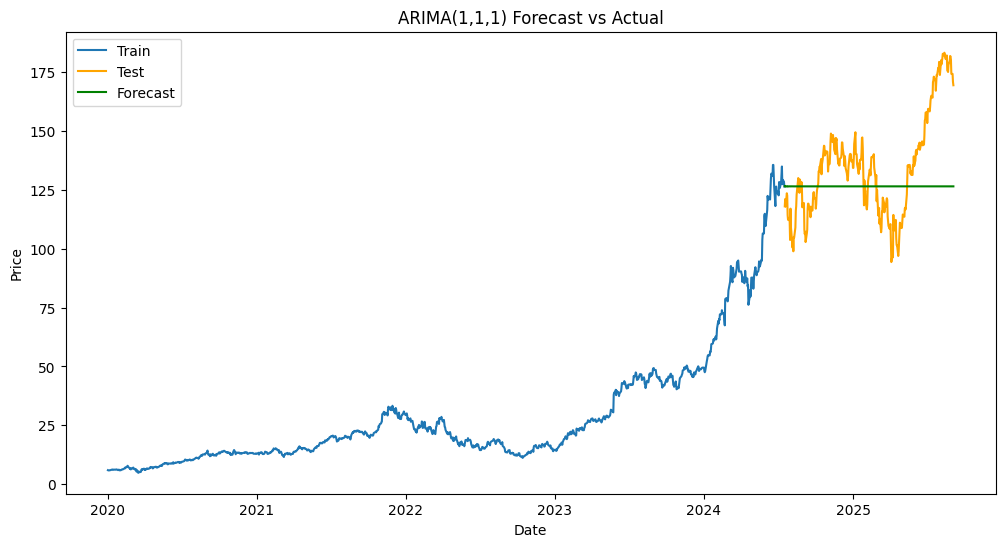

In [8]:
# Actual vs Forecast Plot
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(forecast, label="Forecast", color="green")
plt.title(f"ARIMA({p},{d},{q}) Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()

In [9]:
# Evaluation
results = pd.DataFrame({"Actual": test, "Forecast": forecast}).dropna() 

mse = mean_squared_error(results["Actual"], results["Forecast"])
rmse = math.sqrt(mse)
mae = mean_absolute_error(results["Actual"], results["Forecast"])

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)

MSE : 524.0378038745632
RMSE: 22.891872004590695
MAE : 17.80140902365983
